## Análisis exploratorio de datos

A continuación se presenta un primer análisis basado en los datos del Censo INE 2011, publicados en la página web del Instituto.

Además se utilizan varios conjuntos de datos disponibilizados en la web. Se realizó un pre-procesamiento para seleccionar variables relevantes, reduciendo el volúmen de datos y por tanto los requerimientos informáticos para su acceso.

La base de personas del Censo INE 2011 se filtra según el siguiente criterio:
- Variable "PERMI07" (lugar de residencia 5 años antes) con valores:
    - 3 = en otro departamento
    
Se excluyen habitantes de localidades rurales.

La tabla resultante contiene un departamento de origen, uno de destino y una cantidad de personas que declaran haber vivido antes en el departamento de "origen", habiendo sido relevadas en el departamento de "destino" al momento de la aplicación del formulario censal.

### El perfil de la migración interna

En el apartado 2.4, referido a los antecedentes del estudio de la migración interna en Uruguay, ya se puntualizaban algunas características de la población migrante interna:

- el perfil más joven y feminizado de quienes migran hacia Montevideo.

- el perfil de familias completas, integradas por parejas de entre 30 y 40 años con niños, de quienes migran desde Montevideo.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))
    
# funciones desarrolladas
from functions.agrupar_dfs_censo import *
from functions.graficas import get_bottoms
from functions.cargar_data import cargar_data_eda
from functions.func_demograficas import indice_mascul, porcentaje_sexo

metadatos_figs = {'Author': '''Guillermo D'Angelo'''}

In [2]:
# carga datos
censo, pbi, md = cargar_data_eda()

#### Reclasificaciones de las variables de educación

In [3]:
def reclas_edu_censo(df, old_var, new_var):
    "Reclasifica variables de educación en el Censo INE 2011"
    df.loc[df[old_var].between(1, 3),   new_var] = 1
    df.loc[df[old_var].between(4, 5),   new_var] = 2
    df.loc[df[old_var].between(6, 7),   new_var] = 3
    df.loc[df[old_var].between(8, 10),  new_var] = 4
    df.loc[df[old_var].between(11, 12), new_var] = 5
    return df

censo = reclas_edu_censo(censo, 'PERED03_R', 'PERED03_R_reclass')

# cat 1: Preescolar, Primaria común. Primaria especial
# cat 2: Ciclo Básico Liceo (1ero a 3ro), Ciclo Básico UTU (1ero a 3ro)
# cat 3: Bachillerato Secundario (4to a 6to), Bachillerato UTU (4to a 6to)
# cat 4: Enseñanza Técnica/Formación Profesional UTU, Magisterio o Profesorado, Terciario no universitario
# cat 5: Universidad o Instituto Universitario (Carrera de grado o Licenciatura), Posgrado (Diploma/Maestría/Doctorado)

# para verificar
# pd.DataFrame(censo.groupby(['PERED03_R', 'PERED03_R_reclass']).size()).reset_index()

# completa los valores faltantes (88) de la variable PERED03_1 con los 
# de la variable PERED03_2... Ésta última serían datos relevados en planillas (papel?)
censo.loc[(censo.PERED03_1 == 88), 'PERED03_1'] = censo.PERED03_2

# reclasifica
censo = reclas_edu_censo(censo, 'PERED03_1', 'PERED03_1_reclass')

# verifica
# pd.DataFrame(censo.groupby(['PERED03_1', 'PERED03_1_reclass']).size()).reset_index()

In [4]:
def filter_df_censo(df):
    # un primer análisis abarcando sólo aquellas personas que han migrado entre departamentos
    # (no toma en cuenta quienes han migrado otras localidades dentro del mismo departamento)
    mgr = df.loc[df.PERMI07 == 3].reset_index(drop=True)
    # identifica depto de residencia anterior, creando var "depto_origen"
    mgr.insert(0, 'depto_origen', mgr.loc[:,('PERMI07_2')])
    # convierte a integer
    mgr.loc[:,('depto_origen')] = mgr.loc[:,('depto_origen')].astype(int)
    # renombra DPTO
    mgr.rename(columns={'DPTO': 'depto_destino'}, inplace=True)

    return mgr

In [5]:
mgr_interdep = filter_df_censo(censo)

#### Genera tres data frames con:
- Migrantes de interior a Montevideo (A)
- Migrantes de Montevideo a interior (B)
- Migrantes entres deptos del interior (C)

In [6]:
# genera dataframes por tipología
def filter_df_mig(df, ver_dep_ori, var_dep_des):
    "Corta DFs según origen y destino de la migración"
    # destino Mvdeo.
    a = df[df[var_dep_des] == 1].reset_index()
    # origen Mvdeo. y destino no Mvdeo.
    b = df[(df[ver_dep_ori] == 1) & (df[var_dep_des] != 1)].reset_index()
    # origen y destino no Mvdeo.
    c = df[(df[ver_dep_ori] != 1) & (df[var_dep_des] != 1)].reset_index()
    
    return a, b, c

# aplica función
a, b, c = filter_df_mig(mgr_interdep, 'depto_origen', 'depto_destino')

# enlista los tres DFs
lista_dfs = [a, b, c]

# enlista junto con el censo
lista_dfs_censo = [censo, a, b, c]

In [7]:
# cantidad de personas
print('n de migrantes internos: ', mgr_interdep.shape[0])
print('n de migrantes con origen interior y destino Montevideo: ', a.shape[0])
print('n de migrantes con origen Montevideo y destino Interior: ', b.shape[0])
print('n de migrantes con origen Interior y destino Interior: ', c.shape[0])

n de migrantes internos:  148759
n de migrantes con origen interior y destino Montevideo:  42444
n de migrantes con origen Montevideo y destino Interior:  58655
n de migrantes con origen Interior y destino Interior:  47660


#### Índice de masculinidad

In [8]:
# Índice de masculinidad
help(indice_mascul)

Help on function indice_mascul in module functions.func_demograficas:

indice_mascul(df, var_sexo, redondeo)
    Calcula el índice de masculinidad sobre datos de personas del Censo INE 2011



In [9]:
# índice de masculinidad para todo el país
ind_m_pais = indice_mascul(censo, 'PERPH02', 1)

# índice de masculinidad para migrantes recientes que migran hacia Mvdeo.
ind_m_desagregado = [indice_mascul(x, 'PERPH02', 1) for x in lista_dfs]

printmd("""
El índice de masculinidad para migrantes recientes
**hacia Montevideo** es de **{}**, para migrantes **desde Montevideo hacia el interior** es de **{}**
en tanto que para migrantes **entre departamentos del interior** es de **{}** hombres por cada 100 mujeres.
""".format(ind_m_desagregado[0], ind_m_desagregado[1], ind_m_desagregado[2])
       )

printmd("El índice de masculinidad para el total de la población es de **{}** hombres por cada 100 mujeres.".format(ind_m_pais))


El índice de masculinidad para migrantes recientes
**hacia Montevideo** es de **80.0**, para migrantes **desde Montevideo hacia el interior** es de **92.4**
en tanto que para migrantes **entre departamentos del interior** es de **102.2** hombres por cada 100 mujeres.


El índice de masculinidad para el total de la población es de **92.3** hombres por cada 100 mujeres.

In [79]:
# tamaño de las gráficas (pulgadas)
fig_size = [4, 2.4]

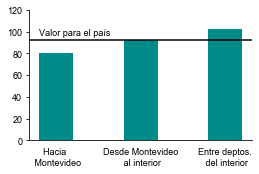

In [80]:
# setea tipo de fuente y tamaño
size = 9
font = {'fontname': 'Arial', 'fontsize': size}

# grafica índices de maculinidad de cada población
fig, ax = plt.subplots(figsize = fig_size)

# ancho de las barras
bars_width=0.40

# ubicación de los grupos
ind = np.arange(3)

# límite en eje Y
plt.ylim(0, 120)

# colores
color = 'darkcyan'

# etiquetas
labels = ['Hacia \n Montevideo',
          'Desde Montevideo\n al interior',
          'Entre deptos.\n del interior']

# plotea
[plt.bar(i, ind_m_desagregado[i],  width=bars_width, color=color, label=labels[i]) for i in range(3)]

# línea de mediana país
plt.axhline(ind_m_pais, color='k')

# agrega texto sobre el valor para todo el país
ax.text(-0.2, ind_m_pais * 1.05, 'Valor para el país', **font)

# oculta ejes superior y derecho
[ax.spines[x].set_visible(False) for x in ["top", "right"]]

# etiquetas en eje X
plt.xticks(ind, labels, **font)
plt.yticks(**font)

# oculta ticks en eje x
plt.tick_params(axis='x', bottom=False, labelbottom=True) 

plt.savefig('mapas_graficas/eda_001_barras_masculinidad.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

plt.show()

In [81]:
# proporción varones/mujeres
help(porcentaje_sexo)

# aplica función para lista extendida de DFs
prop_sexo_dfs = [porcentaje_sexo(x, 'PERPH02') for x in lista_dfs_censo]

# traspone las listas
prop_sexo_tranposed = [[h,i,j,k] for h,i,j,k in zip(*prop_sexo_dfs)]

Help on function porcentaje_sexo in module functions.func_demograficas:

porcentaje_sexo(df, var_sexo)
    Calcula el porcentaje por sexo de un dataframe



In [82]:
# etiquetas a ser utilizadas
labels_extended = ['Total país',
                   'Hacia\n Montevideo',
                   'Desde Mvdeo.\n al interior',
                   'Entre dptos.\n del interior']

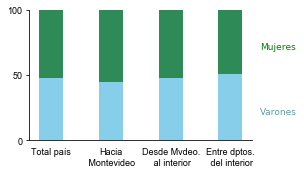

In [70]:
fig, ax = plt.subplots(figsize=fig_size)

# setea paleta de colores
colors = 'skyblue', 'seagreen'

# mínimo y máximo de ejes
plt.ylim(0, 100)

# controla el intervalo de etiquetas en los ticks del eje Y
plt.yticks(np.arange(0, 101, 50))

# n de barras
ind=np.arange(4)

_bottoms = [None, prop_sexo_tranposed[0]]

# grafica
p = [plt.bar(ind, prop_sexo_tranposed[i], width=bars_width, bottom=_bottoms[i], color=colors[i]) for i in range(2)]

# oculta spines
[ax.spines[x].set_visible(False) for x in ["top", "right"]]

# labels
plt.xticks(ind, labels_extended, **font)
plt.yticks(**font)

# oculta ticks en eje x
plt.tick_params(axis='x', bottom=False, labelbottom=True) 

def etiquetar_sexos_barras(x_position, ax_name, colors, font_size):
        # Varones
        ax_name.text(x_position, 20, 'Varones',
        horizontalalignment='left',
        color=colors[0], fontsize=font_size)
        # Mujeres
        ax_name.text(x_position, 70, 'Mujeres',
        horizontalalignment='left',
        color=colors[1], fontsize=font_size)

etiquetar_sexos_barras(3.5, plt, ['cadetblue', 'green'], 9)
        
plt.savefig('mapas_graficas/eda_002_porcentaje_sexo.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

plt.show()

#### Edades medianas

In [ ]:
# edades medianas
emed = [x.PERNA01.median().astype(int) for x in lista_dfs]
e_med_censo = censo.PERNA01.median().astype(int)

printmd("""Las edades medianas son **{}**, **{}** y **{}** años respectivamente. En tanto el valor para el país es de **{}**.
""".format(emed[0], emed[1], emed[2], e_med_censo))

In [ ]:
# grafica edades medianas
fig, ax = plt.subplots()

# n de barras
ind=np.arange(3)

# límite en eje Y
plt.ylim(0, 40)

# controla el intervalo de etiquetas en los ticks del eje Y
plt.yticks(np.arange(0, 41, 10))

# plotea
[plt.bar(i, emed[i],  width=bars_width, color=color, label=labels[i]) for i in range(3)]

# línea de mediana país
plt.axhline(e_med_censo, color='k')

# agrega texto sobre el valor para todo el país
ax.text(-0.2, e_med_censo * 1.05, 'Valor para el país')

# oculta spines superior y derecho
[ax.spines[x].set_visible(False) for x in ["top", "right"]]

# etiquetas en eje X
plt.xticks(ind, labels)

# oculta ticks en eje x
plt.tick_params(axis='x', bottom=False, labelbottom=True) 

plt.savefig('mapas_graficas/eda_003_edades_medianas.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

plt.show()

## Distribución por edades

#### Distribución por grupos de edad

In [ ]:
# GRUPOS DE 0 a 3 años', '4 a 17 años', '18 a 64 años', '65 o más años'
grupos_edad = [grupos_de_edad(x, 'PERNA01')  for x in lista_dfs_censo]

# traspone las series enlistada y las devuelve en una lista 
grupos_edad_t = [[h,i,j,k] for h,i,j,k in zip(*grupos_edad)]

In [ ]:
fig, ax = plt.subplots()

# n de barras
ind = np.arange(4)

# setea paleta de colores
colors = 'tab:olive', 'tab:cyan', 'tab:purple', 'silver'

# mínimo y máximo de ejes
plt.ylim(0, 100)

# controla el intervalo de etiquetas en los ticks del eje Y
# plt.yticks(np.arange(0, 101, 25))

# enlista los fondos calculados con la función get_bottoms
_bottoms = get_bottoms(grupos_edad_t)

# grafica
p = [plt.bar(ind, grupos_edad_t[i], width=bars_width, color=colors[i], bottom=_bottoms[i]) for i in range(4)]

# oculta spines
[ax.spines[x].set_visible(False) for x in ["top", "right"]]

# labels
plt.xticks(ind, labels_extended)

_labels = ['0 a 3 años',
           '4 a 17 años',
           '18 a 64 años',
           '65 o más años']

# oculta ticks en eje x
plt.tick_params(axis='x', bottom=False, labelbottom=True) 

# leyenda
plt.legend((p[0], p[1], p[2], p[3]),
           _labels,
           bbox_to_anchor=(1.45, 1),
           loc='upper right',
           frameon=False,
           labelspacing=1)

plt.savefig('mapas_graficas/eda_004_dist_grupos_edad.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

plt.show()

In [ ]:
# GRUPOS DE 0 a 3 años', '4 a 17 años', '18 a 64 años', '65 o más años'
grupos_dependencia = [grupos_de_dependencia(x, 'PERNA01')  for x in lista_dfs_censo]

# traspone las series enlistada y las devuelve en una lista 
grupos_dependencia_t = [[h,i,j,k] for h,i,j,k in zip(*grupos_dependencia)]

In [ ]:
fig, ax = plt.subplots()

# n de barras
ind = np.arange(4)

# mínimo y máximo de ejes
plt.ylim(0, 100)

# enlista los fondos calculados con la función get_bottoms
_bottoms = get_bottoms(grupos_dependencia_t)

# grafica
p = [plt.bar(ind, grupos_dependencia_t[i], width=bars_width, color=colors[i], bottom=_bottoms[i]) for i in range(3)]

# oculta spines
[ax.spines[x].set_visible(False) for x in ["top", "right"]]

# labels
plt.xticks(ind, labels_extended)

_labels = ['0 a 14 años',
           '15 a 64 años',
           '65 o más años']

# oculta ticks en eje x
plt.tick_params(axis='x', bottom=False, labelbottom=True) 

# leyenda
plt.legend((p[0], p[1], p[2]),
           _labels,
           bbox_to_anchor=(1.45, 1),
           loc='upper right',
           frameon=False,
           labelspacing=1)


plt.savefig('mapas_graficas/eda_005_grupos_dependencia.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

plt.show()

In [ ]:
# agrupa datos
edades_censo = agrupar_por_edades(censo, 'PERNA01')
edades = [agrupar_por_edades(x, 'PERNA01') for x in lista_dfs]

In [ ]:
# ploteo de edades
fig, ax = plt.subplots(figsize=(10, 5))

# plote líne con valores para todas las personas
plt.plot(edades_censo.edad,
         edades_censo.porc_pers,
         label='Todas las personas',
         linewidth=1,
         color='grey',
         alpha=0.6)

# plotea las otras tres distribuciones
colors = ['firebrick', 'darkcyan', 'darkmagenta']

[plt.plot(edades[i].edad, edades[i].porc_pers, color=colors[i], label=labels[i], linewidth=2) for i in range(3)]


[ax.spines[x].set_visible(False) for x in ["top", "right"]]

plt.legend( loc='upper right', frameon=False, labelspacing=1)

# setea límites de ejex x e y
plt.ylim(0, 10)
plt.xlim(0, 80)

plt.savefig('mapas_graficas/eda_006_distribucion_edades.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

plt.show()

## **Educación**

In [ ]:
def get_edu_asist(df, var_edu):
    "Calcula los porcentajes de personas que asisten a centros educativos"
    df_filtered = df.loc[df[var_edu].between(1, 4), var_edu]
    values = df_filtered.value_counts(normalize=True,sort=False).mul(100)
    
    return values

In [ ]:
# aplica a la lista de 4 DFs
edu_asist = [get_edu_asist(x, 'PERED01') for x in lista_dfs_censo]

# traspone las series enlistada y las devuelve en una lista 
edu_asist_list = [[h,i,j,k] for h,i,j,k in zip(*edu_asist)]

In [ ]:
fig, ax = plt.subplots()

# n de barras
ind = np.arange(4)

# setea paleta de colores
colors = 'tab:olive', 'tab:cyan', 'tab:purple', 'silver'

# mínimo y máximo de ejes
plt.ylim(0, 100)

# enlista los fondos calculados con la función get_bottoms
_bottoms = get_bottoms(edu_asist_list)

# grafica
p = [plt.bar(ind, edu_asist_list[i], width=bars_width, color=colors[i], bottom=_bottoms[i]) for i in range(4)]

# oculta spines
[ax.spines[x].set_visible(False) for x in ["top", "right"]]

# labels
plt.xticks(ind, labels_extended)

_labels = ['Sí, a un establecimiento público',
           'Sí, a un establecimiento privado',
           'No asiste pero asistió',
           'Nunca asistió']

# oculta ticks en eje x
plt.tick_params(axis='x', bottom=False, labelbottom=True) 

# leyenda
plt.legend((p[0], p[1], p[2], p[3]),
           _labels,
           bbox_to_anchor=(1.65, 1),
           loc='upper right',
           frameon=False,
           labelspacing=1)

plt.savefig('mapas_graficas/eda_007_asistencia_educacion.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

plt.show()

#### **Nivel educativo que cursa actualmente**

In [ ]:
edunivel = [x.PERED03_R_reclass.value_counts(normalize=True,sort=False).mul(100).sort_index() for x in lista_dfs_censo]

# enlista
edunivel_list = [[h,i,j,k] for h,i,j,k in zip(*edunivel)]

In [ ]:
fig, ax = plt.subplots()

# ubicación de los grupos
ind = np.arange(4)

# mínimo y máximo de ejes
plt.ylim(0, 100)

# setea paleta de colores
colors = 'tab:olive', 'tab:cyan', 'grey', 'tomato','indigo'

# pairwise sum para completar los "bottom"
_bottoms = get_bottoms(edunivel_list)

# grafica
p = [plt.bar(ind, edunivel_list[i], width=bars_width, color=colors[i], bottom=_bottoms[i]) for i in range(5)]

# oculta spines
[ax.spines[x].set_visible(False) for x in ["top", "right"]]

# labels
plt.xticks(ind, labels_extended)

_labels = ['Primaria o prescolar',
           'Ciclo básico (liceo o UTU)',
           'Bachillerato (liceo o UTU)',
           'Terciario no universitario',
           'Universitario (grado o posgrado)']

# oculta ticks en eje x
plt.tick_params(axis='x', bottom=False, labelbottom=True) 

# leyenda
plt.legend((p[0], p[1], p[2], p[3], p[4]),
           _labels,
           bbox_to_anchor=(1.65, 1),
           loc='upper right',
           frameon=False,
           labelspacing=1)

plt.savefig('mapas_graficas/eda_008_nivel_educativo_actual.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

plt.show()

#### **Nivel más alto cursado**

In [ ]:
max_edunivel = [x.PERED03_1_reclass.value_counts(normalize=True,sort=False).mul(100).sort_index()  for x in lista_dfs_censo]

# enlista
max_edunivel_list = [[h,i,j,k] for h,i,j,k in zip(*max_edunivel)]

In [ ]:
fig, ax = plt.subplots()

ind = np.arange(4)

# pairwise sum para completar los "bottom"
_bottoms = get_bottoms(max_edunivel_list)

# mínimo y máximo de ejes
plt.ylim(0, 100)

# grafica
p = [plt.bar(ind, max_edunivel_list[i], width=bars_width, color=colors[i], bottom=_bottoms[i]) for i in range(5)]

# oculta spines
[ax.spines[x].set_visible(False) for x in ["top", "right"]]

# labels
plt.xticks(ind, labels_extended)

_labels = ['Primaria o prescolar',
           'Ciclo básico (liceo o UTU)',
           'Bachillerato (liceo o UTU)',
           'Terciario no universitario',
           'Universitario (grado o posgrado)']

# oculta ticks en eje x
plt.tick_params(axis='x', bottom=False, labelbottom=True) 

# leyenda
plt.legend((p[0], p[1], p[2], p[3], p[4]),
           _labels,
           bbox_to_anchor=(1.65, 1),
           loc='upper right',
           frameon=False,
           labelspacing=1)

plt.savefig('mapas_graficas/eda_009_nivel_mas_alto_alcanzado.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)
plt.show()

## más cosas para ver:
- relación entre sexo y distancia de lamigración
- caracterizar hogares migrantes (cantidad de niños, edades promedio)